**POTATO DISEASE CLASSIFICATION**

**Import libraries**

In [1]:
import os                         
import numpy as np         
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

**Set the constants**

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=25

**Load the data**

In [3]:
from tensorflow.python.ops.gen_array_ops import size
df=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato/data",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 2166 files belonging to 3 classes.


In [4]:
class_names=df.class_names
class_names

['Early_blight', 'Healthy', 'Late_blight']

In [5]:
len(df)                 # 68*32

68

In [6]:
for image_batch, label_batch in df.take(1):
  print(image_batch.shape)                 
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 2 1 2 2 0 2 0 2 2 0 2 2 2 0 0 2 2 2 2 0 2 2 0 0 2 2 2 0 0 2]


**Visualize images from dataset**

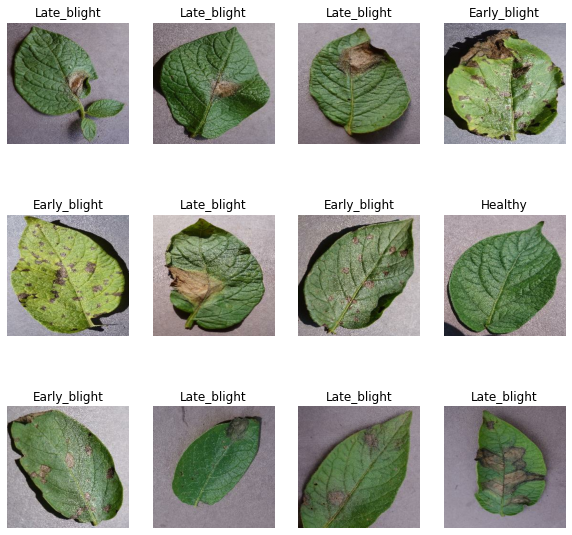

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in df.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")


**Split the dataset**

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [7]:
# 80%-Train data, 10%- Validation data, 10% - Test data

def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size=int(val_split * ds_size)

  train_ds = df.take(train_size)
  val_ds = df.skip(train_size).take(val_size)
  test_ds = df.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [8]:
 train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [9]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


**Cache, Shuffle and prefetch the Dataset**

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

**Model Building**

**Creating a layer for resizing and normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [11]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),               
    layers.experimental.preprocessing.Rescaling(1.0/255)           
])

**Data augmentation**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),               
    layers.experimental.preprocessing.RandomRotation(0.2)           
])

**Appyling Data augmentation to train data**

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data augmentation.

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)   
n_classes = 3

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

**Compiling the model**

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric.

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

**Training the Network**

In [17]:
history = model.fit(
    train_ds,
    epochs=25,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/25
54/54 [==============================] - 184s 698ms/step - loss: 0.8621 - accuracy: 0.4994 - val_loss: 0.7548 - val_accuracy: 0.6354
Epoch 2/25
54/54 [==============================] - 19s 345ms/step - loss: 0.6537 - accuracy: 0.6782 - val_loss: 0.5976 - val_accuracy: 0.7083
Epoch 3/25
54/54 [==============================] - 19s 346ms/step - loss: 0.4405 - accuracy: 0.8148 - val_loss: 0.4979 - val_accuracy: 0.7812
Epoch 4/25
54/54 [==============================] - 19s 344ms/step - loss: 0.3426 - accuracy: 0.8455 - val_loss: 0.2026 - val_accuracy: 0.9115
Epoch 5/25
54/54 [==============================] - 19s 344ms/step - loss: 0.2070 - accuracy: 0.9190 - val_loss: 0.1361 - val_accuracy: 0.9479
Epoch 6/25
54/54 [==============================] - 19s 348ms/step - loss: 0.1456 - accuracy: 0.9473 - val_loss: 0.2653 - val_accuracy: 0.8854
Epoch 7/25
54/54 [==============================] - 19s 344ms/step - loss: 0.1730 - accuracy: 0.9369 - val_loss: 0.2671 - val_accuracy: 0.880

**Testing the Model**

In [18]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 6s 126ms/step - loss: 0.1607 - accuracy: 0.9390


[0.1606501340866089, 0.9390243887901306]

**Plotting the accuracy and loss curves**

In [19]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 25, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

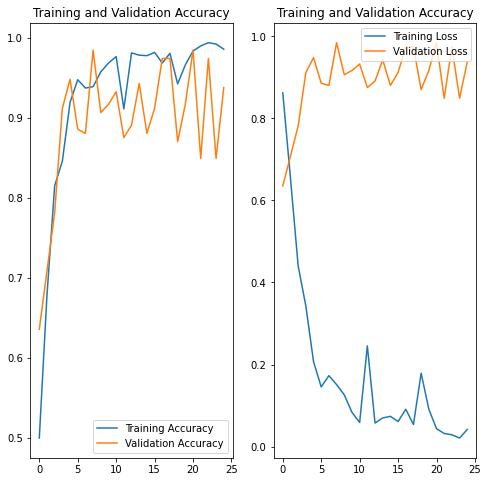

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_acc, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Accuracy")
plt.show()

**Run prediction on sample image**

First image to predict
Actual label: Early_blight
Predicted label: Early_blight


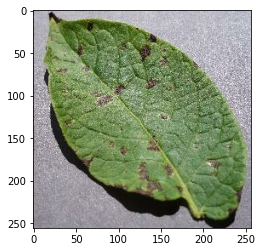

In [22]:
for images_batch, labels_batch in test_ds.take(1):
   
   first_image = images_batch[0].numpy().astype('uint8')
   first_label = labels_batch[0]

   print("First image to predict")
   plt.imshow(first_image)
   print("Actual label:",class_names[first_label])

   batch_prediction = model.predict(images_batch)
   print("Predicted label:",class_names[np.argmax(batch_prediction[0])])      # np.argmax([ ,   ,  ]) =0(class) - the item at 0th location is maximum                                                                      
  


**Function for inference**

In [23]:
def predict(model,img):
  img_to_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_to_array = tf.expand_dims(img_to_array, 0)     #create a batch

  predictions = model.predict(img_to_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

**Run the inference on few sample images**

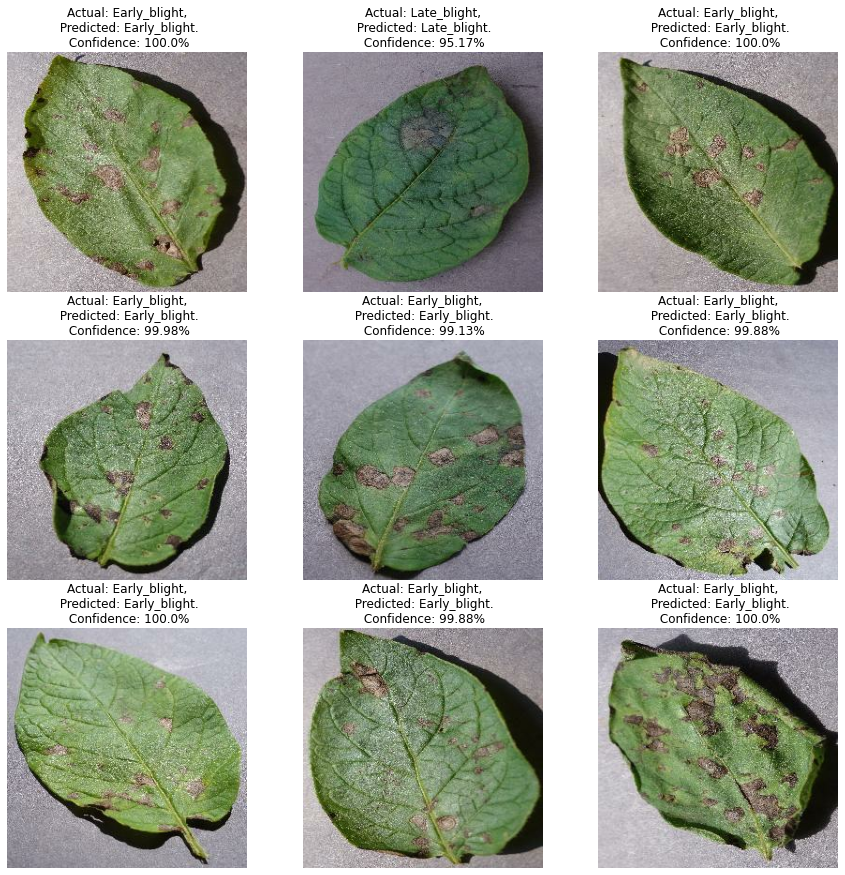

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%") #display just the actual label

    plt.axis("off")

**Save the model**

In [26]:
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/Potato/models") + [0]])+1
model.save(f"/content/drive/MyDrive/Potato/models/{model_version}") 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Potato/models/3/assets


In [27]:
model.save("/content/drive/MyDrive/Potato/potatoes.h5")